In [2]:
import pickle
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [3]:
import numpy as np
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
# Định nghĩa cross-validation phù hợp đảm bảo tỷ lệ fraud/non-fraud được giữ nguyên trong mỗi fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
from sklearn.tree import DecisionTreeClassifier

# Tạo Pipeline gồm 2 bước: SMOTE và Decision Tree
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),        # chuẩn hóa trước
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Grid các siêu tham số, lưu ý thay đổi tên tham số của Decision Tree thành 'dt__'
dt_param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': ['sqrt', 'log2', None]
}

# Sử dụng GridSearchCV với scoring = 'roc_auc'
dt_grid = GridSearchCV(estimator=pipeline_dt,
                       param_grid=dt_param_grid,
                       cv=cv,
                       scoring='average_precision',
                       n_jobs=-1,
                       verbose=1)

# Huấn luyện mô hình trên tập huấn luyện
dt_grid.fit(X_train_val, y_train_val)

# Lấy mô hình tốt nhất
best_model_dt = dt_grid.best_estimator_
print("Best Parameters:", dt_grid.best_params_)

# Dự đoán trên các tập dữ liệu
y_test_pred = best_model_dt.predict(X_test)

# In kết quả đánh giá trên từng tập
print("\nKết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__max_features': None, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}

Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.05      0.48      0.10        42

    accuracy                           0.94      6747
   macro avg       0.53      0.71      0.53      6747
weighted avg       0.99      0.94      0.97      6747



In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Tạo Pipeline gồm: chuẩn hóa → Random Forest (không dùng SMOTE)
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),        # chuẩn hóa trước
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Grid siêu tham số với class_weight
rf_param_grid = {
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt'],
    'rf__bootstrap': [True],
    'rf__class_weight': ['balanced']
}

# GridSearchCV với scoring = average_precision (PR AUC)
rf_grid = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=rf_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện trên tập train/val
rf_grid.fit(X_train_val, y_train_val)

# Lấy mô hình tốt nhất
best_model_rf = rf_grid.best_estimator_
print("Random Forest - Best Parameters:", rf_grid.best_params_)

# Dự đoán trên tập test
y_test_pred = best_model_rf.predict(X_test)

# Đánh giá
print("\nRandom Forest - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Random Forest - Best Parameters: {'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}

Random Forest - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.07      0.57      0.12        42

    accuracy                           0.95      6747
   macro avg       0.53      0.76      0.55      6747
weighted avg       0.99      0.95      0.97      6747



In [8]:
import pickle
import os

filename = "best_models.pkl"

# Bước 1: Load lại dictionary từ file
if os.path.exists(filename):
    with open(filename, "rb") as file:
        best_models = pickle.load(file)

    # Bước 2: Thay thế model Random Forest bằng model mới của bạn
    best_models["Random Forest"] = best_model_rf  # Giả sử đây là model mới

    # Bước 3: Lưu lại dictionary đã cập nhật
    with open(filename, "wb") as file:
        pickle.dump(best_models, file)

    print("✅ Đã cập nhật mô hình Random Forest trong file.")
else:
    print("❌ File chưa tồn tại, cần train lại toàn bộ mô hình hoặc tạo mới file.")


✅ Đã cập nhật mô hình Random Forest trong file.


In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Tạo thư mục để lưu hình nếu chưa có
output_dir = "qq_plots"
os.makedirs(output_dir, exist_ok=True)

# Lấy danh sách các cột số
num_cols = X_train.select_dtypes(include=['float64', 'int']).columns

# Vẽ và lưu từng Q-Q plot
for col in num_cols:
    plt.figure(figsize=(6, 4))
    stats.probplot(X_train[col], dist="norm", plot=plt)
    plt.title(f"Q-Q plot: {col}", fontsize=10)
    filename = os.path.join(output_dir, f"qq_plot_{col}.png")
    plt.savefig(filename)
    plt.close()  # Đóng figure để tránh tràn bộ nhớ

print(f"✅ Đã lưu {len(num_cols)} Q-Q plots vào thư mục '{output_dir}'")



✅ Đã lưu 10 Q-Q plots vào thư mục 'qq_plots'


In [7]:
# Sử dụng randomized vì grid quá mất thời gian
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))  # dùng probability để hỗ trợ predict_proba nếu cần
])

# 2. Định nghĩa không gian tìm kiếm siêu tham số
svm_random_grid = {
    'svc__C': uniform(0.1, 10),
    'svc__gamma': ['scale'],
    'svc__kernel': ['rbf']
}

# 3. Thiết lập RandomizedSearchCV với scoring = 'average_precision'
svm_search = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=svm_random_grid,
    n_iter=5,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 4. Huấn luyện trên tập train/val
svm_search.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_svm = svm_search.best_estimator_
print("SVM - Best Parameters:", svm_search.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_svm.predict(X_test)

# 7. Đánh giá mô hình
print("\nSVM - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
SVM - Best Parameters: {'svc__C': 1.6601864044243653, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

SVM - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      6705
           1       0.03      0.90      0.06        42

    accuracy                           0.82      6747
   macro avg       0.52      0.86      0.48      6747
weighted avg       0.99      0.82      0.90      6747



In [8]:
from sklearn.neighbors import KNeighborsClassifier

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# 2. Định nghĩa không gian siêu tham số
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

# 3. Sử dụng GridSearchCV với scoring = 'average_precision' (PR AUC)
knn_grid = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=knn_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/validation
knn_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_knn = knn_grid.best_estimator_
print("KNN - Best Parameters:", knn_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_knn.predict(X_test)

# 7. Đánh giá trên tập test
print("\nKNN - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
KNN - Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}

KNN - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.07      0.38      0.12        42

    accuracy                           0.97      6747
   macro avg       0.53      0.68      0.55      6747
weighted avg       0.99      0.97      0.98      6747



In [9]:
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. Tạo pipeline gồm: chuẩn hóa → SMOTE → GaussianNB
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])
# Danh sách các priors cần thử nghiệm
priors_grid = [
    [0.99, 0.01],
    [0.95, 0.05],
    [0.9, 0.1],
    [0.85, 0.15],
    [0.8, 0.2]
]

# Grid param với priors là siêu tham số
nb_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8],
    'nb__priors': priors_grid
}

# 3. Thiết lập GridSearchCV với scoring = 'average_precision'
nb_grid = GridSearchCV(
    estimator=pipeline_nb,
    param_grid=nb_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/val
nb_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_nb = nb_grid.best_estimator_
print("Naïve Bayes - Best Parameters:", nb_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_nb.predict(X_test)

# 7. Đánh giá mô hình
print("\nNaïve Bayes - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Naïve Bayes - Best Parameters: {'nb__priors': [0.99, 0.01], 'nb__var_smoothing': 1e-08}

Naïve Bayes - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      6705
           1       0.03      0.52      0.06        42

    accuracy                           0.89      6747
   macro avg       0.51      0.71      0.50      6747
weighted avg       0.99      0.89      0.94      6747



In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Tạo pipeline: chuẩn hóa → SMOTE → Bagging(DecisionTree)
pipeline_bag = Pipeline([
    ('bag', BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42))
])

# 2. Không gian siêu tham số cho Bagging + class_weight
bagging_param_grid = {
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 1.0],
    'bag__max_features': [0.5, 1.0],
    'bag__bootstrap': [True, False],
    'bag__estimator__class_weight': ['balanced']
}

# 3. GridSearchCV với scoring = 'average_precision'
bagging_grid = GridSearchCV(
    estimator=pipeline_bag,
    param_grid=bagging_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện trên tập train/val
bagging_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_bag = bagging_grid.best_estimator_
print("Bagging - Best Parameters:", bagging_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_bag.predict(X_test)

# 7. Đánh giá mô hình
print("\nBagging - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Bagging - Best Parameters: {'bag__bootstrap': True, 'bag__estimator__class_weight': 'balanced', 'bag__max_features': 1.0, 'bag__max_samples': 1.0, 'bag__n_estimators': 100}

Bagging - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.60      0.14      0.23        42

    accuracy                           0.99      6747
   macro avg       0.80      0.57      0.61      6747
weighted avg       0.99      0.99      0.99      6747



In [11]:
from xgboost import XGBClassifier

# 1. Tạo pipeline: chuẩn hóa → SMOTE → XGBoost
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
])

# 2. Định nghĩa không gian siêu tham số (có thêm scale_pos_weight)
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__scale_pos_weight': [1, 3, 5, 10]  
}

# 3. Thiết lập GridSearchCV
xgb_grid = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring='average_precision',
    n_jobs=-1,
    verbose=1
)

# 4. Huấn luyện mô hình trên tập train/val
xgb_grid.fit(X_train_val, y_train_val)

# 5. Lấy mô hình tốt nhất
best_model_xgb = xgb_grid.best_estimator_
print("XGBoost - Best Parameters:", xgb_grid.best_params_)

# 6. Dự đoán trên tập test
y_test_pred = best_model_xgb.predict(X_test)

# 7. Đánh giá kết quả
print("\nXGBoost - Kết quả trên tập Test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Fitting 5 folds for each of 192 candidates, totalling 960 fits
XGBoost - Best Parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 3, 'xgb__subsample': 0.8}

XGBoost - Kết quả trên tập Test:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.06      0.52      0.11        42

    accuracy                           0.95      6747
   macro avg       0.53      0.74      0.54      6747
weighted avg       0.99      0.95      0.97      6747



In [5]:
import os 
# Đường dẫn đến file lưu best models
filename = "best_models.pkl"

# Nếu file đã tồn tại thì load các mô hình và in các siêu tham số ra
if os.path.exists(filename):
    print(f"File '{filename}' đã tồn tại. Tải các mô hình")
    with open(filename, "rb") as file:
        best_models = pickle.load(file)
else:
    # Dictionary chứa các best model
    best_models = {
        "Decision Tree": best_model_dt,
        "Random Forest": best_model_rf,
        "SVM": best_model_svm,
        "Naive Bayes": best_model_nb,
        "KNN": best_model_knn,
        "Bagging": best_model_bag,
        "XGBoost": best_model_xgb
    }

    # Lưu dictionary các mô hình đã huấn luyện vào file .pkl
    with open(filename, "wb") as file:
        pickle.dump(best_models, file)
    print(f"\nCác best models đã được lưu vào file '{filename}'.")

File 'best_models.pkl' đã tồn tại. Tải các mô hình


In [6]:
# In các siêu tham số của từng mô hình
print("\n--- In các siêu tham số của các mô hình đã lưu ---")
for model_name, model in best_models.items():
    print(f"\nSiêu tham số của mô hình {model_name}:")
    try:
        # Lấy danh sách các siêu tham số thông qua hàm get_params() của scikit-learn
        params = model.get_params()
        for param, value in params.items():
            print(f"  {param}: {value}")
    except Exception as e:
        print(f"  Không thể lấy siêu tham số cho mô hình {model_name}: {e}")


--- In các siêu tham số của các mô hình đã lưu ---

Siêu tham số của mô hình Decision Tree:
  memory: None
  steps: [('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=5, random_state=42))]
  transform_input: None
  verbose: False
  scaler: StandardScaler()
  smote: SMOTE(random_state=42)
  dt: DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)
  scaler__copy: True
  scaler__with_mean: True
  scaler__with_std: True
  smote__k_neighbors: 5
  smote__random_state: 42
  smote__sampling_strategy: auto
  dt__ccp_alpha: 0.0
  dt__class_weight: None
  dt__criterion: entropy
  dt__max_depth: 10
  dt__max_features: None
  dt__max_leaf_nodes: None
  dt__min_impurity_decrease: 0.0
  dt__min_samples_leaf: 2
  dt__min_samples_split: 5
  dt__min_weight_fraction_leaf: 0.0
  dt

--- Báo cáo phân loại cho mô hình Decision Tree trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.05      0.48      0.10        42

    accuracy                           0.94      6747
   macro avg       0.53      0.71      0.53      6747
weighted avg       0.99      0.94      0.97      6747


Confusion Matrix for Decision Tree:


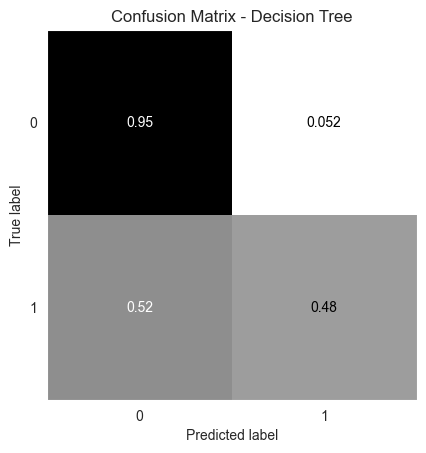

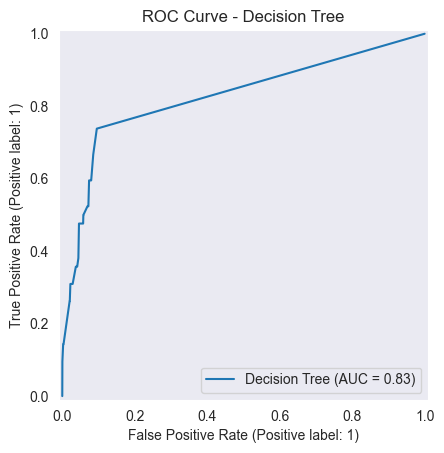

--- Báo cáo phân loại cho mô hình Random Forest trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.07      0.57      0.12        42

    accuracy                           0.95      6747
   macro avg       0.53      0.76      0.55      6747
weighted avg       0.99      0.95      0.97      6747


Confusion Matrix for Random Forest:


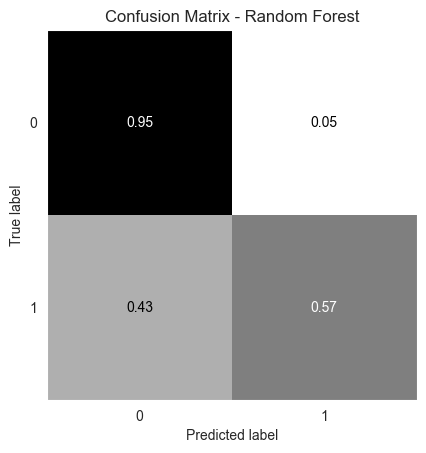

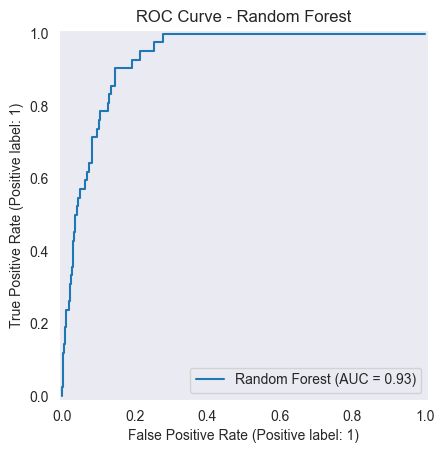

--- Báo cáo phân loại cho mô hình SVM trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      6705
           1       0.03      0.90      0.06        42

    accuracy                           0.82      6747
   macro avg       0.52      0.86      0.48      6747
weighted avg       0.99      0.82      0.90      6747


Confusion Matrix for SVM:


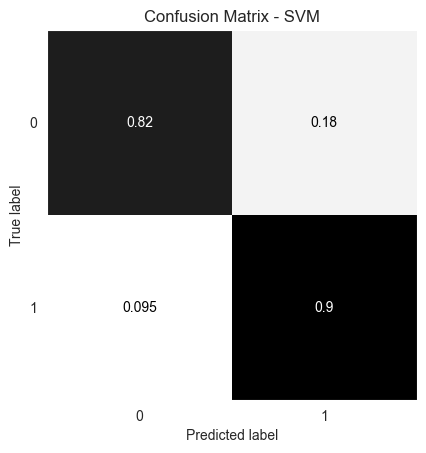

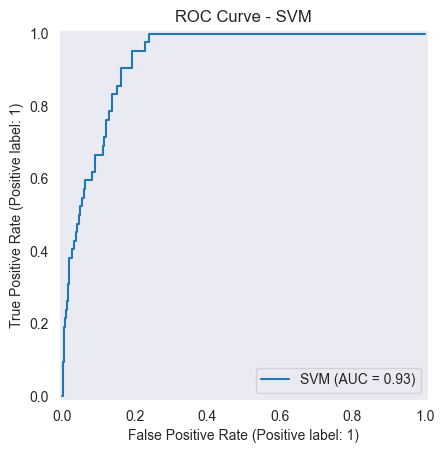

--- Báo cáo phân loại cho mô hình Naive Bayes trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      6705
           1       0.03      0.52      0.06        42

    accuracy                           0.89      6747
   macro avg       0.51      0.71      0.50      6747
weighted avg       0.99      0.89      0.94      6747


Confusion Matrix for Naive Bayes:


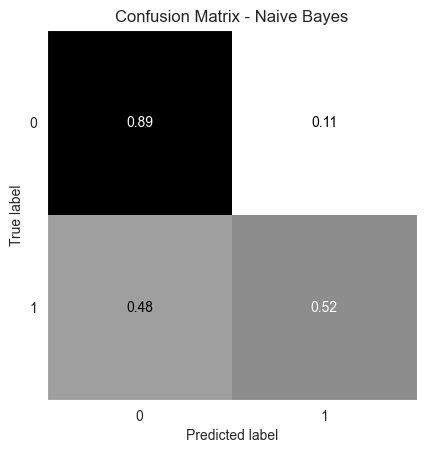

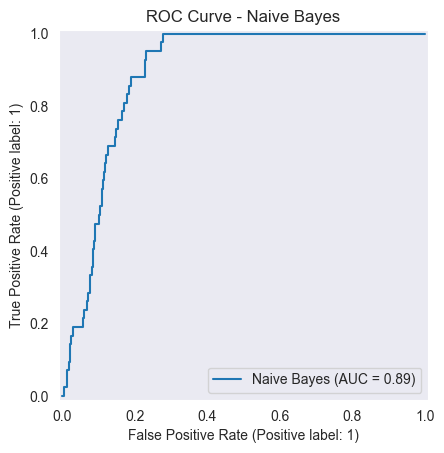

--- Báo cáo phân loại cho mô hình KNN trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.07      0.38      0.12        42

    accuracy                           0.97      6747
   macro avg       0.53      0.68      0.55      6747
weighted avg       0.99      0.97      0.98      6747


Confusion Matrix for KNN:


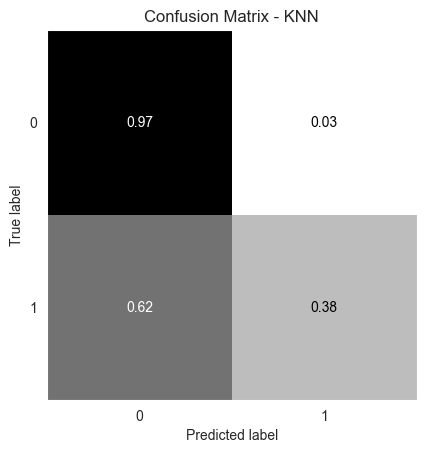

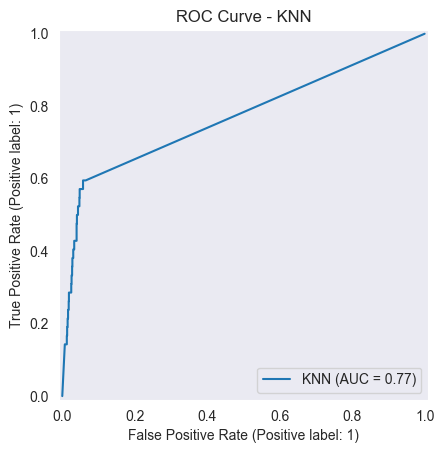

--- Báo cáo phân loại cho mô hình Bagging trên tập Test ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.60      0.14      0.23        42

    accuracy                           0.99      6747
   macro avg       0.80      0.57      0.61      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix for Bagging:


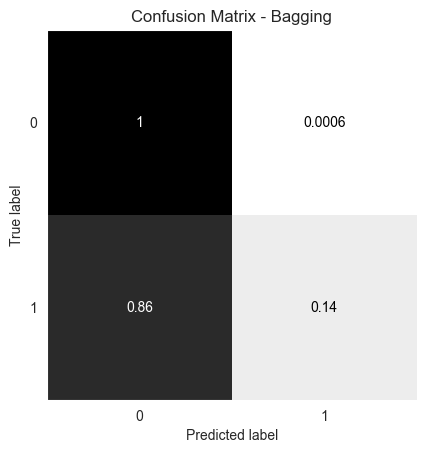

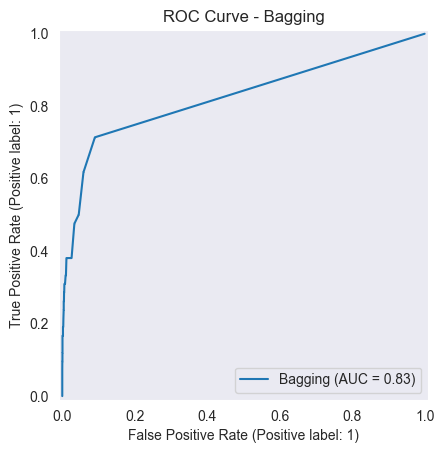

--- Báo cáo phân loại cho mô hình XGBoost trên tập Test ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.06      0.52      0.11        42

    accuracy                           0.95      6747
   macro avg       0.53      0.74      0.54      6747
weighted avg       0.99      0.95      0.97      6747


Confusion Matrix for XGBoost:


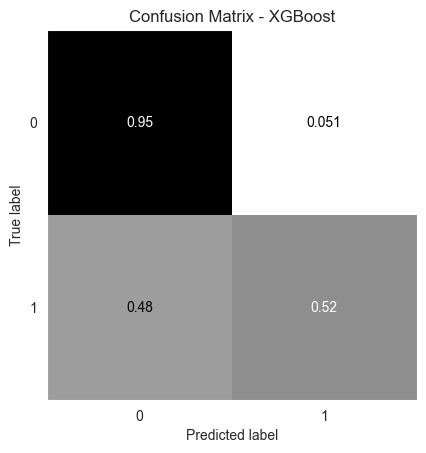

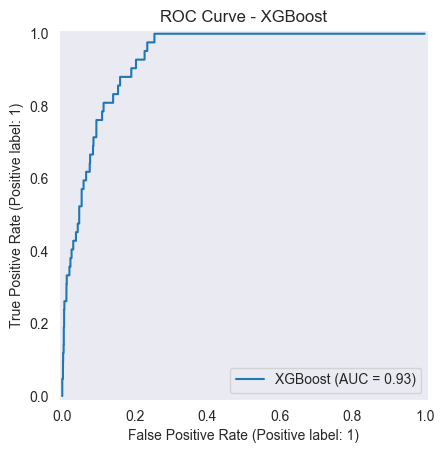

In [8]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
# Re-fit (huấn luyện lại) các mô hình trên tập train_val
for model_name, model in best_models.items():
    # Huấn luyện lại mô hình trên tập train_val
    model.fit(X_train_val, y_train_val)
    
    # Dự đoán trên tập test
    y_test_pred = model.predict(X_test)
    
    # In báo cáo phân loại cho mô hình trên tập test
    print(f"--- Báo cáo phân loại cho mô hình {model_name} trên tập Test ---")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    
    # In ma trận nhầm lẫn với normalize theo tỷ lệ (true)
    print(f"\nConfusion Matrix for {model_name}:")
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_test_pred,
        display_labels=[0, 1],
        normalize='true', 
        cmap='Greys', 
        colorbar=False
    )
    plt.title("Confusion Matrix - " + model_name)
    plt.grid(False)
    plt.show()

    # Vẽ đồ thị ROC
    roc_disp = RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        name=model_name
    )
    plt.title("ROC Curve - " + model_name)
    plt.grid(False)
    plt.show()
    


 --- Báo cáo phân loại cho mô hình Decision Tree ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.05      0.48      0.10        42

    accuracy                           0.94      6747
   macro avg       0.53      0.71      0.53      6747
weighted avg       0.99      0.94      0.97      6747



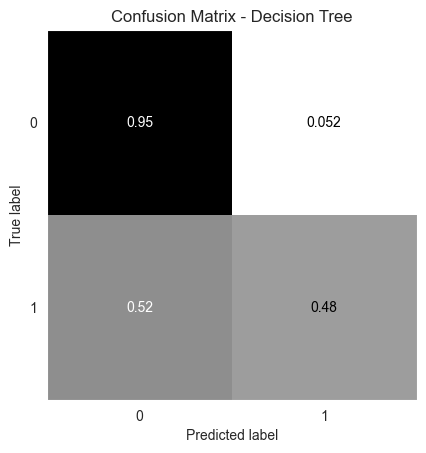

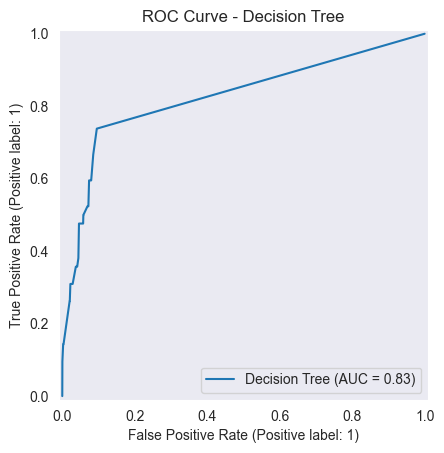


 --- Báo cáo phân loại cho mô hình Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.07      0.57      0.12        42

    accuracy                           0.95      6747
   macro avg       0.53      0.76      0.55      6747
weighted avg       0.99      0.95      0.97      6747



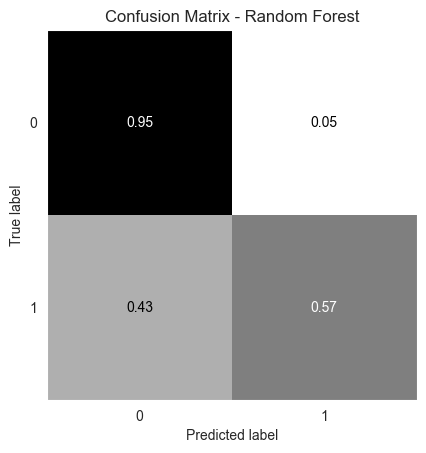

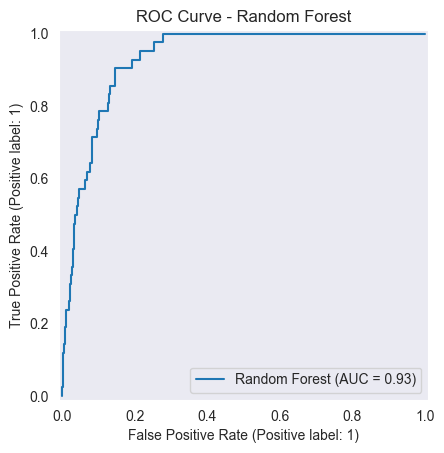


 --- Báo cáo phân loại cho mô hình SVM ---
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      6705
           1       0.03      0.76      0.06        42

    accuracy                           0.84      6747
   macro avg       0.51      0.80      0.49      6747
weighted avg       0.99      0.84      0.91      6747



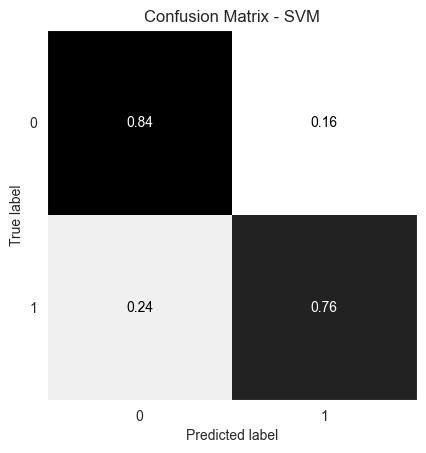

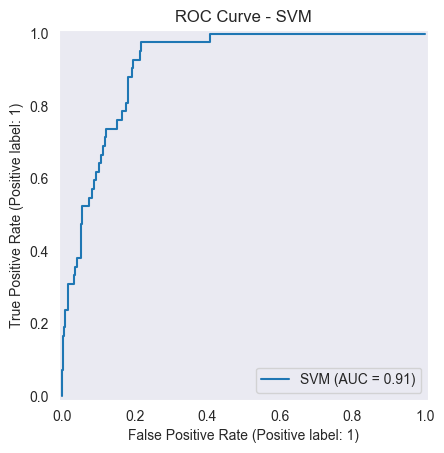


 --- Báo cáo phân loại cho mô hình Naive Bayes ---
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      6705
           1       0.02      0.88      0.05        42

    accuracy                           0.79      6747
   macro avg       0.51      0.83      0.46      6747
weighted avg       0.99      0.79      0.87      6747



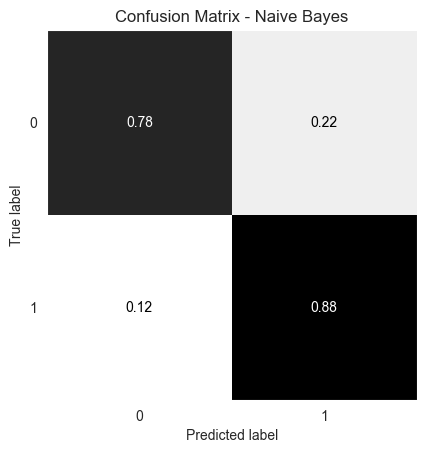

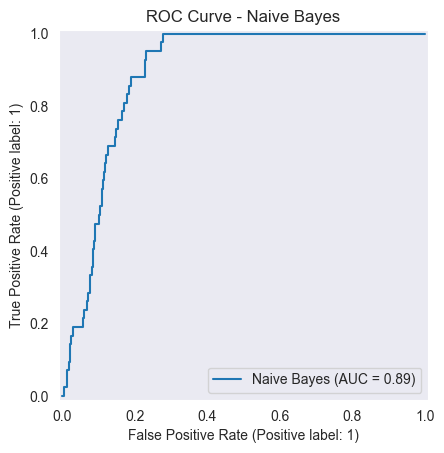


 --- Báo cáo phân loại cho mô hình KNN ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6705
           1       0.07      0.31      0.11        42

    accuracy                           0.97      6747
   macro avg       0.53      0.64      0.55      6747
weighted avg       0.99      0.97      0.98      6747



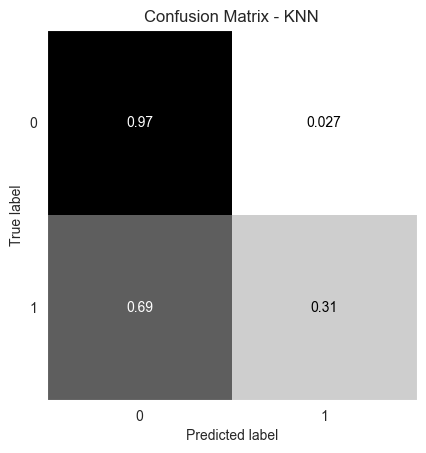

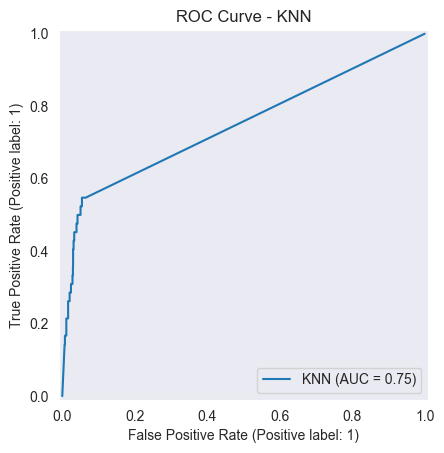


 --- Báo cáo phân loại cho mô hình Bagging ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6705
           1       0.20      0.29      0.24        42

    accuracy                           0.99      6747
   macro avg       0.60      0.64      0.61      6747
weighted avg       0.99      0.99      0.99      6747



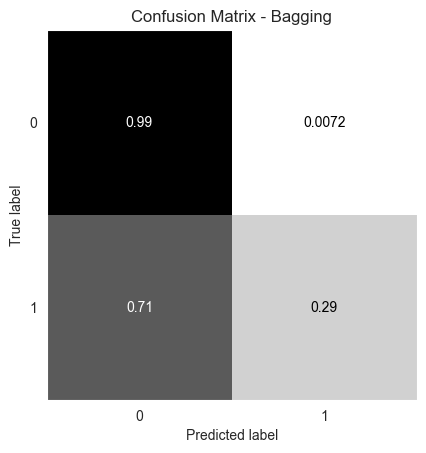

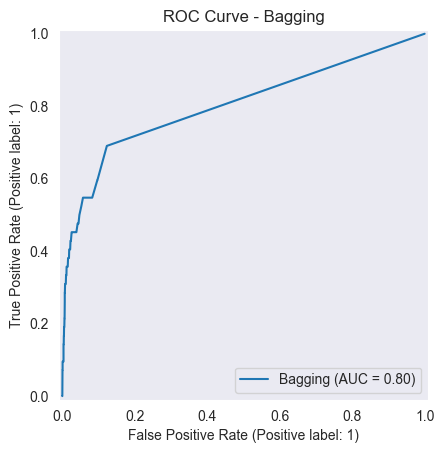


 --- Báo cáo phân loại cho mô hình XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6705
           1       0.06      0.52      0.11        42

    accuracy                           0.95      6747
   macro avg       0.53      0.74      0.54      6747
weighted avg       0.99      0.95      0.97      6747



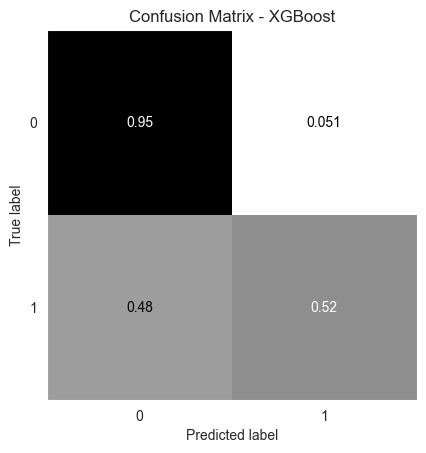

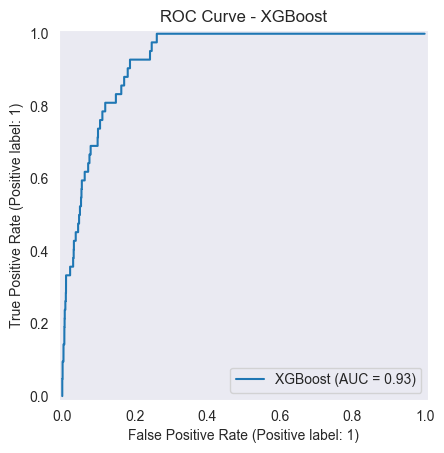

In [9]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

# Áp dụng SMOTE + Chuẩn hóa + Mô hình
for model_name, base_model in best_models.items():
    
    # Tạo pipeline gồm: chuẩn hóa, SMOTE, và mô hình
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', base_model)
    ])

    # Huấn luyện pipeline trên tập train_val
    pipeline.fit(X_train_val, y_train_val)

    # Dự đoán trên tập test (chỉ dùng scaler, không SMOTE)
    y_test_pred = pipeline.predict(X_test)

    # Báo cáo kết quả
    print(f"\n --- Báo cáo phân loại cho mô hình {model_name} ---")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    # Ma trận nhầm lẫn
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_test_pred,
        display_labels=[0, 1],
        normalize='true',
        cmap='Greys',
        colorbar=False
    )
    plt.title("Confusion Matrix - " + model_name)
    plt.grid(False) 
    plt.show()

    # Vẽ đường cong ROC
    try:
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=model_name)
        plt.title("ROC Curve - " + model_name)
        plt.grid(False) 
        plt.show()
    except:
        print(f" Không thể vẽ ROC cho {model_name} (có thể thiếu hỗ trợ xác suất).")



XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6705
           1       0.60      0.14      0.23        42

    accuracy                           0.99      6747
   macro avg       0.80      0.57      0.61      6747
weighted avg       0.99      0.99      0.99      6747


Confusion Matrix:


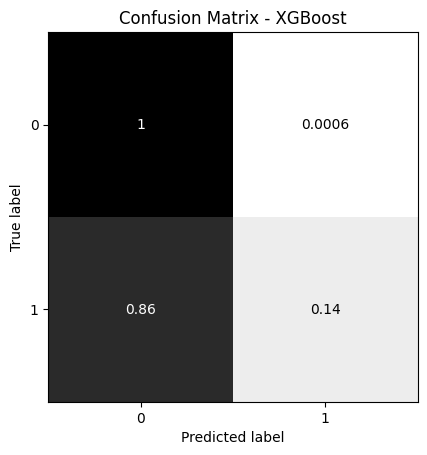

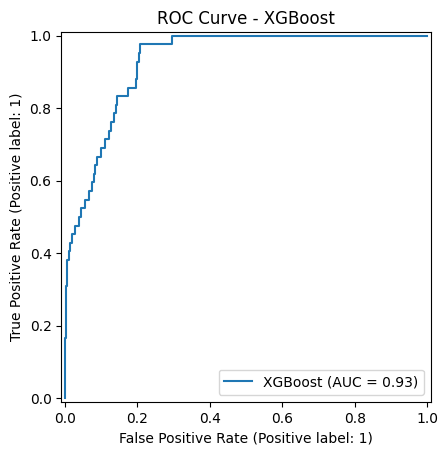

In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Khởi tạo mô hình XGBoost (cấu hình gốc)
xgb_model = XGBClassifier()

# Huấn luyện mô hình
xgb_model.fit(X_train_val, y_train_val)

# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test)

# In kết quả (classification report)
print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

# Hiển thị ma trận nhầm lẫn (normalized)
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    display_labels=[0, 1],
    normalize='true',
    cmap='Greys',
    colorbar=False
)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Hiển thị ROC Curve
try:
    RocCurveDisplay.from_estimator(
        xgb_model,
        X_test,
        y_test,
        name="XGBoost"
    )
    plt.title("ROC Curve - XGBoost")
    plt.show()
except AttributeError:
    print("⚠️ Mô hình XGBoost không hỗ trợ 'predict_proba' để vẽ ROC.")
